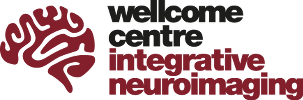


# `funpack`

> Paul McCarthy &lt;paul.mccarthy@ndcn.ox.ac.uk&gt; ([WIN@FMRIB](https://www.win.ox.ac.uk/)) 

`funpack` is a command-line program which you can use to extract data from UK BioBank (and other tabular) data.

You can give `funpack` one or more input files (e.g. `.csv`, `.tsv`), and it will merge them together, perform some preprocessing, and produce a single output file. 

A large number of rules are built into `funpack` which are specific to the UK BioBank data set. But you can control and customise everything that `funpack` does to your data, including which rows and columns to extract, and which cleaning/processing steps to perform on each column.

The `funpack` source code is available at https://git.fmrib.ox.ac.uk/fsl/funpack. You can install `funpack` into a Python environment using `pip`:

    pip install fmrib-unpack
    
Get command-line help by typing:

    funpack -h
    
*The examples in this notebook assume that you have installed `funpack` 1.9.0 or newer.*

In [ ]:
funpack -V

### Contents

1. [Overview](#Overview)
   1. [Import](#1.-Import)
   2. [Cleaning](#2.-Cleaning)
   3. [Processing](#3.-Processing)
   4. [Export](#4.-Export)
2. [Examples](#Examples)
3. [Import examples](#Import-examples)
   1. [Selecting variables (columns)](#Selecting-variables-(columns))
      1. [Selecting individual variables](#Selecting-individual-variables)
      2. [Selecting variable ranges](#Selecting-variable-ranges)
      3. [Selecting variables with a file](#Selecting-variables-with-a-file)
      4. [Selecting variables from pre-defined categories](#Selecting-variables-from-pre-defined-categories)
   2. [Selecting subjects (rows)](#Selecting-subjects-(rows))
      1. [Selecting individual subjects](#Selecting-individual-subjects)
      2. [Selecting subject ranges](#Selecting-subject-ranges)
      3. [Selecting subjects from a file](#Selecting-subjects-from-a-file)
      4. [Selecting subjects by variable value](#Selecting-subjects-by-variable-value)
      5. [Excluding subjects](#Excluding-subjects)
   3. [Selecting visits](#Selecting-visits)
      1. [Evaluating expressions across visits](#Evaluating-expressions-across-visits)
   4. [Merging multiple input files](#Merging-multiple-input-files)
      1. [Merging by subject](#Merging-by-subject)
      2. [Merging by column](#Merging-by-column)
      3. [Naive merging](#Merging-by-column)
4. [Cleaning examples](#Cleaning-examples)
   1. [NA insertion](#NA-insertion)
   2. [Variable-specific cleaning functions](#Variable-specific-cleaning-functions)
   3. [Categorical recoding](#Categorical-recoding)
   4. [Child value replacement](#Child-value-replacement)
5. [Processing examples](#Processing-examples)
   1. [Sparsity check](#Sparsity-check)
   2. [Redundancy check](#Redundancy-check)
   3. [Categorical binarisation](#Categorical-binarisation)
6. [Custom cleaning, processing and loading - funpack plugins](#Custom-cleaning,-processing-and-loading---funpack-plugins)
   1. [Custom cleaning functions](#Custom-cleaning-functions)
   2. [Custom processing functions](#Custom-processing-functions)
   3. [Custom file loaders](#Custom-file-loaders)
7. [Miscellaneous topics](#Miscellaneous-topics)
   1. [Non-numeric data](#Non-numeric-data)
   2. [Dry run](#Dry-run)
   3. [Built-in rules](#Built-in-rules)
   4. [Using a configuration file](#Using-a-configuration-file)
   5. [Reporting unknown variables](#Reporting-unknown-variables)
   6. [Low-memory mode](#Low-memory-mode)   

# Overview

`funpack` performs the following steps:

## 1. Import


   All data files are loaded in, unwanted columns and subjects are dropped, and the data files are merged into a single table (a.k.a. data frame). Multiple files can be merged according to an index column (e.g. subject ID). Or, if the input files contain the same columns/subjects, they can be naively concatenated along rows or columns.


## 2. Cleaning


The following cleaning steps are applied to each column:

1. **NA value replacement:** Specific values for some columns are replaced with NA, for example, variables where a value of `-1` indicates *Do not know*.
    
    
2. **Variable-specific cleaning functions:** Certain columns are re-formatted - for example, the [ICD10](https://en.wikipedia.org/wiki/ICD-10) disease codes can be converted to integer representations.
   
   
3. **Categorical recoding:** Certain categorical columns are re-coded. 


4. **Child value replacement:** NA values within some columns which are dependent upon other columns may have values inserted based on the values of their parent columns. 


## 3. Processing


During the processing stage, columns may be removed, merged, or expanded into additional columns. For example, a categorical column may be expanded into a set of binary columns, one for each category.

A column may also be removed on the basis of being too sparse, or being redundant with respect to another column.


## 4. Export


The processed data can be saved as a `.csv`, `.tsv`, or `.hdf5` file.

# Examples

Throughout these examples, we are going to use a few command line options, which you will probably **not** normally want to use:
 - `-ow` (short for `--overwrite`): This tells `funpack` not to complain if the output file already exists.
 - `-q` (short for `--quiet`): This tells `funpack` to be quiet. 
 
Without the `-q` option, `funpack` can be quite verbose, which can be annoying, but is very useful when things go wrong. A good strategy is to tell `funpack` to produce verbose output using the `--noisy` (`-n` for short) option, and to send all of its output to a log file with the `--log_file` (or `-lf`) option.  For example:

    funpack -n -n -n -lf log.txt out.tsv in.tsv 
    
Here's the first example input data set, with UK BioBank-style column names:

In [ ]:
cat data_01.tsv

The numbers in each column name typically represent: 

1. The variable ID
2. The visit, for variables which were collected at multiple points in time.
3. The "instance", for multi-valued variables.

Note that one **variable** is typically associated with several **columns**, although we're keeping things simple for this first example - there is only one visit for each variable, and there are no mulit-valued variables.

> _Most but not all_ variables in the UK BioBank contain data collected at different visits, the times that the participants visited a UK BioBank assessment centre. However there are some variables (e.g. [ICD10 diagnosis codes](https://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=41202)) for which this is not the case.

# Import examples

## Selecting variables (columns)

You can specify which variables you want to load in the following ways, using the `--variable` (`-v` for short) and `--category` (`-c` for short) command line options:

 * By variable ID
 * By variable ranges
 * By a text file which contains the IDs you want to keep.
 * By pre-defined variable categories
 * By column name
 
### Selecting individual variables

Simply provide the IDs of the variables you want to extract:

In [ ]:
funpack -q -ow -v 1 -v 5 out.tsv data_01.tsv
cat out.tsv

### Selecting variable ranges

The `--variable`/`-v` option accepts MATLAB-style ranges of the form `start:step:stop` (where the `stop` is inclusive):

In [ ]:
funpack -q -ow -v 1:3:10 out.tsv data_01.tsv
cat out.tsv

### Selecting variables with a file
If your variables of interest are listed in a plain-text file, you can simply pass that file:

In [ ]:
echo -e "1\n6\n9" > vars.txt
funpack -q -ow -v vars.txt out.tsv data_01.tsv
cat out.tsv

### Selecting variables from pre-defined categories

Some UK BioBank-specific categories are baked into `funpack`, but you can also define your own categories - you just need to create a `.tsv` file, and pass it to `funpack` via the `--category_file` (`-cf` for short):

In [ ]:
echo -e "ID\tCategory\tVariables"      > custom_categories.tsv
echo -e "1\tCool variables\t1:5,7"    >> custom_categories.tsv
echo -e "2\tUncool variables\t6,8:10" >> custom_categories.tsv
cat custom_categories.tsv

Use the `--category` (`-c` for short) to select categories to output. You can refer to categories by their ID:

In [ ]:
funpack -q -ow -cf custom_categories.tsv -c 1 out.tsv data_01.tsv
cat out.tsv

Or by name:

In [ ]:
funpack -q -ow -cf custom_categories.tsv -c uncool out.tsv data_01.tsv
cat out.tsv

### Selecting column names

If you are working with data that has non-UK BioBank style column names, you can use the `--column` (`-co` for short) to select individual columns by their name, rather than the variable with which they are associated. The `--column` option accepts full column names, and also shell-style wildcard patterns:

In [ ]:
funpack -q -ow -co 4-0.0 -co "??-0.0" out.tsv data_01.tsv
cat out.tsv

## Selecting subjects (rows)

`funpack` assumes that the first column in every input file is a subject ID. You can specify which subjects you want to load via the `--subject` (`-s` for short) option. You can specify subjects in the same way that you specified variables above, and also:

 * By specifying a conditional expression on variable values - only subjects for which the expression evaluates to true will be imported
 * By specifying subjects to exclude
 
### Selecting individual subjects

In [ ]:
funpack -q -ow -s 1 -s 3 -s 5 out.tsv data_01.tsv
cat out.tsv

### Selecting subject ranges

In [ ]:
funpack -q -ow -s 2:2:10 out.tsv data_01.tsv
cat out.tsv

### Selecting subjects from a file

In [ ]:
echo -e "5\n6\n7\n8\n9\n10" > subjects.txt
funpack -q -ow -s subjects.txt out.tsv data_01.tsv
cat out.tsv

### Selecting subjects by variable value

The `--subject` option accepts *variable expressions* - you can write an expression performing numerical comparisons on variables (denoted with a leading `v`) and combine these expressions using boolean algebra. Only subjects for which the expression evaluates to true will be imported. For example, to only import subjects where variable 1 is greater than 10, and variable 2 is less than 70, you can type:

In [ ]:
funpack -q -ow -sp -s "v1 > 10 && v2 < 70" out.tsv data_01.tsv
cat out.tsv

The following symbols can be used in variable expressions:

| Symbol                    | Meaning                         |
|---------------------------|---------------------------------|
| `==`                      | equal to                        |
| `!=`                      | not equal to                    |
| `>`                       | greater than                    |
| `>=`                      | greater than or equal to        |
| `<`                       | less than                       |
| `<=`                      | less than or equal to           |
| `na`                      | N/A                             |
| `&&`                      | logical and                     |
| <code>&#x7c;&#x7c;</code> | logical or                      |
| `~`                       | logical not                     |
| `contains`                | Contains sub-string             |
| `all`                     | all columns must meet condition |
| `any`                     | any column must meet condition  |
| `()`                      | to denote precedence            |

Non-numeric (i.e. string) variables can be used in these expressions in conjunction with the `==`, `!=`, and `contains` operators. An example of such an expression is given in the section on [non-numeric data](#Non-numeric-data), below.

The `all` and `any` symbols allow you to control how an expression is evaluated across multiple columns which are associated with one variable (e.g. separate columns for each visit). We will give an example of this in the section on [selecting visits](#Selecting-visits), below.

### Excluding subjects

The `--exclude` (`-ex` for short) option allows you to exclude subjects - it accepts individual IDs, an ID range, or a file containing IDs. The `--exclude`/`-ex` option takes precedence over the `--subject`/`-s` option:

In [ ]:
funpack -q -ow -s 1:8 -ex 5:10 out.tsv data_01.tsv
cat out.tsv

## Selecting visits

Many variables in the UK BioBank data contain observations at multiple points in time, or visits. `funpack` allows you to specify which visits you are interested in. Here is an example data set with variables that have data for multiple visits (remember that the second number in the column names denotes the visit):

In [ ]:
cat data_02.tsv

We can use the `--visit` (`-vi` for short) option to get just the last visit for each variable:

In [ ]:
funpack -q -ow -vi last out.tsv data_02.tsv
cat out.tsv

You can also specify which visit you want by its number:

In [ ]:
funpack -q -ow -vi 1 out.tsv data_02.tsv
cat out.tsv

> Variables which are not associated with specific visits (e.g. [ICD10 diagnosis codes](https://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=41202)) will not be affected by the `-vi` option.

### Evaluating expressions across visits

The variable expressions described above in the section on [selecting subjects](#Selecting-subjects-by-variable-value) will be applied to all of the columns associated with a variable. By default, an expression will evaluate to true where the values in _any_ column asssociated with the variable evaluate to true. For example, we can extract the data for subjects where the values of any column of variable 2 were less than 50: 

In [ ]:
funpack -q -ow -v 2 -s 'v2 < 50' out.tsv data_02.tsv
cat out.tsv

We can use the `any` and `all` operators to control how an expression is evaluated across the columns of a variable. For example, we may only be interested in subjects for whom all columns of variable 2 were greater than 50:

In [ ]:
funpack -q -ow -v 2 -s 'all(v2 < 50)' out.tsv data_02.tsv
cat out.tsv

We can use `any` and `all` in expressions involving multiple variables:

In [ ]:
funpack -q -ow -v 2,3 -s 'any(v2 < 50) && all(v3 >= 40)' out.tsv data_02.tsv
cat out.tsv

## Merging multiple input files

If your data is split across multiple files, you can specify how `funpack` should merge them together. 

### Merging by subject

For example, let's say we have these two input files (shown side-by-side):

In [ ]:
echo " " | paste data_03.tsv - data_04.tsv

Note that each file contains different variables, and different, but overlapping, subjects. By default, when you pass these files to `funpack`, it will output the intersection of the two files (more formally known as an *inner join*), i.e. subjects which are present in both files:

In [ ]:
funpack -q -ow out.tsv data_03.tsv data_04.tsv
cat out.tsv

If you want to keep all subjects, you can instruct `funpack` to output the union (a.k.a. *outer join*) via the `--merge_strategy` (`-ms` for short) option:

In [ ]:
funpack -q -ow -ms outer out.tsv data_03.tsv data_04.tsv
cat out.tsv

### Merging by column

Your data may be organised in a different way. For example, these next two files contain different groups of subjects, but overlapping columns:

In [ ]:
echo " " | paste data_05.tsv - data_06.tsv

In this case, we need to tell `funpack` to merge along the row axis, rather than along the column axis. We can do this with the `--merge_axis` (`-ma` for short) option:

In [ ]:
funpack -q -ow -ma rows out.tsv data_05.tsv data_06.tsv
cat out.tsv

Again, if we want to retain all columns, we can tell `funpack` to perform an outer join with the `-ms` option:

In [ ]:
funpack -q -ow -ma rows -ms outer out.tsv data_05.tsv data_06.tsv
cat out.tsv

### Naive merging

Finally, your data may be organised such that you simply want to "paste", or concatenate them together, along either rows or columns. For example, your data files might look like this:

In [ ]:
echo " " | paste data_07.tsv - data_08.tsv

Here, we have columns for different variables on the same set of subjects, and we just need to concatenate them together horizontally. We do this by using `--merge_strategy naive` (`-ms naive` for short):

In [ ]:
funpack -q -ow -ms naive out.tsv data_07.tsv data_08.tsv
cat out.tsv

For files which need to be concatenated vertically, such as these:

In [ ]:
echo " " | paste data_09.tsv - data_10.tsv

We need to tell `funpack` which axis to concatenate along, again using the `-ma` option:

In [ ]:
funpack -q -ow -ms naive -ma rows out.tsv data_09.tsv data_10.tsv
cat out.tsv

# Cleaning examples

Once the data has been imported, a sequence of cleaning steps are applied to each column.

## NA insertion

For some variables it may make sense to discard or ignore certain values. For example, if an individual selects *"Do not know"* to a question such as *"How much milk did you drink yesterday?"*, that answer will be coded with a specific value (e.g. `-1`). It does not make any sense to include these values in most analyses, so `funpack` can be used to mark such values as *Not Available (NA)*.

A large number of NA insertion rules, specific to UK BioBank variables, are coded into `funpack`, and are applied when you use the `-cfg fmrib` option (see the section below on [built-in rules](#Built-in-rules)). You can also specify your own rules via the `--na_values` (`-nv` for short) option. 

Let's say we have this data set:

In [ ]:
cat data_11.tsv

For variable 1, we want to ignore values of -1, for variable 2 we want to ignore -1 and 0, and for variable 3 we want to ignore 1 and 2:

In [ ]:
funpack -q -ow -nv 1 " -1" -nv 2 " -1,0" -nv 3 "1,2" out.tsv data_11.tsv
cat out.tsv

 > The `--na_values` option expects two arguments:
 >  * The variable ID
 >  * A comma-separated list of values to replace with NA

## Variable-specific cleaning functions

A small number of cleaning/preprocessing functions are built into `funpack`, which can be applied to specific variables. For example, some variables in the UK BioBank contain ICD10 disease codes, which may be more useful if converted to a numeric format. Imagine that we have some data with ICD10 codes:

In [ ]:
cat data_12.tsv

We can use the `--clean` (`-cl` for short) option with the built-in `codeToNumeric` cleaning function to convert the codes to a numeric representation:

In [ ]:
funpack -q -ow -cl 1 "codeToNumeric('icd10')" out.tsv data_12.tsv
cat out.tsv

> The `--clean` option expects two arguments:
>  * The variable ID
>  * The cleaning function to apply. Some cleaning functions accept arguments - refer to the command-line help for a summary of available functions.
>
> You can define your own cleaning functions by passing them in as a `--plugin_file` (see the [section on custom plugins below](#Custom-cleaning,-processing-and-loading----funpack-plugins)).

### Example: flattening hierarchical data

Several variables in the UK Biobank (including the ICD10 disease categorisations) are organised in a hierarchical manner - each value is a child of a more general parent category. The `flattenHierarchical` cleaninng function can be used to replace each value in a data set with the value that corresponds to a parent category. Let's apply this to our example ICD10 data set. 

In [ ]:
funpack -q -ow -cl 1 "flattenHierarchical(name='icd10')" out.tsv data_12.tsv
cat out.tsv

### Aside: ICD10 mapping file

`funpack` has a feature specific to these ICD10 disease categorisations - you can use the `--icd10_map_file` (`-imf` for short) option to tell `funpack` to save a file which contains a list of all ICD10 codes that were present in the input data, and the corresponding numerical codes that `funpack` generated:

In [ ]:
funpack -q -ow -cl 1 "codeToNumeric('icd10')" -imf icd10_codes.tsv out.tsv data_12.tsv
cat icd10_codes.tsv

## Categorical recoding

You may have some categorical data which is coded in an awkward manner, such as in this example, which encodes the amount of some item that an individual has consumed:

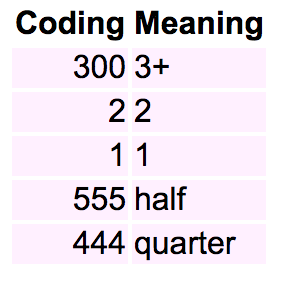

You can use the `--recoding` (`-re` for short) option to recode data like this into something more useful. For example, given this data:

In [ ]:
cat data_13.tsv

Let's recode it to be more monotonic:

In [ ]:
funpack -q -ow -re 1 "300,444,555" "3,0.25,0.5" out.tsv data_13.tsv
cat out.tsv

The `--recoding` option expects three arguments:
 * The variable ID
 * A comma-separated list of the values to be replaced
 * A comma-separated list of the values to replace them with

## Child value replacement

Imagine that we have these two questions:

 * **1**: *Do you currently smoke cigarettes?*
 * **2**: *How many cigarettes did you smoke yesterday?*
 
Now, question 2 was only asked if the answer to question 1 was *"Yes"*. So for all individuals who answered *"No"* to question 1, we will have a missing value for question 2. But for some analyses, it would make more sense to have a value of 0, rather than NA, for these subjects.

`funpack` can handle these sorts of dependencies by way of *child value replacement*. For question 2, we can define a conditional variable expression such that when both question 2 is NA and question 1 is *"No"*, we can insert a value of 0 into question 2.

This scenario is demonstrated in this example data set (where, for question 1 values of `1` and `0` represent *"Yes"* and *"No"* respectively):

In [ ]:
cat data_14.tsv

We can fill in the values for variable 2 by using the `--child_values` (`-cv` for short) option:

In [ ]:
funpack -q -ow -cv 2 "v1 == 0" "0" out.tsv data_14.tsv
cat out.tsv

> The `--child_values` option expects three arguments:
> * The variable ID
> * An expression evaluating some condition on the parent variable(s)
> * A value to replace NA with where the expression evaluates to true.

# Processing examples

After every column has been cleaned, the entire data set undergoes a series of processing steps. The processing stage may result in columns being removed or manipulated, or new columns being added.

The processing stage can be controlled with these options:
 * `--prepend_process` (`-ppr` for short): Apply a processing function before the built-in processing 
 * `--append_process` (`-apr` for short): Apply a processing function after the built-in processing
 
A default set of processing steps are applied when you apply the `fmrib` configuration profile by using `-cfg fmrib` - see the section on [built-in rules](#Built-in-rules).

The `--prepend_process` and `--append_process` options require two arguments:
 * The variable ID(s) to apply the function to, or `all` to denote all variables.
 * The processing function to apply. The available processing functions are listed in the command line help, or you can write your own and pass it in as a plugin file ([see below](#Custom-cleaning,-processing-and-loading----funpack-plugins)).

## Sparsity check

The `removeIfSparse` process will remove columns that are deemed to have too many missing values. If we take this data set:

In [ ]:
cat data_15.tsv

Imagine that our analysis requires at least 8 values per variable to work. We can use the `minpres` option to`funpack` to drop any columns which do not meet this threshold:

In [ ]:
funpack -q -ow -apr all "removeIfSparse(minpres=8)" out.tsv data_15.tsv
cat out.tsv

You can also specify `minpres` as a proportion, rather than an absolute number. e.g.:

In [ ]:
funpack -q -ow -apr all "removeIfSparse(minpres=0.65, abspres=False)" out.tsv data_15.tsv
cat out.tsv

## Redundancy check

You may wish to remove columns which contain redundant information. The `removeIfRedundant` process calculates the pairwise correlation between all columns, and removes columns with a correlation above a threshold that you provide. Imagine that we have this data set: 

In [ ]:
cat data_16.tsv

The data in column `2-0.0` is effectively equivalent to the data in column `1-0.0`, so is not of any use to us. We can tell `funpack` to remove it like so:

In [ ]:
funpack -q -ow -apr all "removeIfRedundant(0.9)" out.tsv data_16.tsv
cat out.tsv

The `removeIfRedundant` process can also calculate the correlation of the patterns of missing values between variables - Consider this example:

In [ ]:
cat data_17.tsv

All three columns are highly correlated, but the pattern of missing values in column `3-0.0` is different to that of the other columns. 

If we use the `nathres` option, `funpack` will only remove columns where the correlation of both present and missing values meet the thresholds. Note that the column which contains more missing values will be the one that gets removed:

In [ ]:
funpack -q -ow -apr all "removeIfRedundant(0.9, nathres=0.6)" out.tsv data_17.tsv
cat out.tsv

## Categorical binarisation

The `binariseCategorical` process takes a column containing categorical labels, and replaces it with
a set of new binary columns, one for each category. Imagine that we have this data:

In [ ]:
cat data_18.tsv

We can use the `binariseCategorical` process to split column `1-0.0` into a separate column for each category:

In [ ]:
funpack -q -ow -apr 1 "binariseCategorical" out.tsv data_18.tsv
cat out.tsv

There are a few options to `binariseCategorical`, including controlling whether the original column is removed, and also the naming of the newly created columns:

In [ ]:
funpack -q -ow -apr 1 "binariseCategorical(replace=False, nameFormat='{vid}:{value}')" out.tsv data_18.tsv
cat out.tsv

# Custom cleaning, processing and loading - `funpack` plugins

If you want to apply some specific cleaning or processing function to a variable, you can code your functions up in python, and then tell `funpack` to apply them.

As an example, let's say we have some data like this:

In [ ]:
cat data_19.tsv

## Custom cleaning functions

But for our analysis, we are only interested in the even values for columns 1 and 2. Let's write a cleaning function which replaces all odd values with NA:

In [ ]:
cat plugin_1.py | pygmentize

To use our custom cleaner function, we simply pass our plugin file to `funpack` using the `--plugin_file` (`-p` for short) option:

In [ ]:
funpack -q -ow -p plugin_1.py -cl 1 drop_odd_values -cl 2 drop_odd_values out.tsv data_19.tsv
cat out.tsv

## Custom processing functions

Recall that **cleaning** functions are applied independently to each column, whereas **processing** functions may be applied to multiple columns simultaneously, and may add and/or remove columns. Let's say we want to derive a new column from columns `1-0.0` and `2-0.0` in our example data set. Our plugin file might look like this:

In [ ]:
cat plugin_2.py | pygmentize

Again, to use our plugin, we pass it to `funpack` via the `--plugin`/`-p` option:

In [ ]:
funpack -q -ow -p plugin_2.py -apr "1,2" "sum_squares" out.tsv data_19.tsv
cat out.tsv

## Custom file loaders

You might want to load some auxillary data which is in an awkward format that cannot be automatically parsed by `funpack`. For example, you may have a file which has acquisition date information separated into *year*, *month* and *day* columns, e.g.:

In [ ]:
cat data_20.tsv

These three columns would be better loaded as a single column. So we can write a plugin to load this file for us. We need to write two functions:

 * A "sniffer" function, which returns information about the columns contained in the file
 * A "loader" function which loads the file, returning it as a `pandas.DataFrame`.

In [ ]:
cat plugin_3.py | pygmentize

And to see it in action:

In [ ]:
funpack -q -ow -p plugin_3.py -l data_20.tsv my_datefile_loader out.tsv data_20.tsv
cat out.tsv

# Miscellaneous topics


## Non-numeric data

Many UK Biobank variables contain non-numeric data, such as alpha-numeric codes and unstructured text. If you want to select subjects oon the basis of such columns, [variable expressions](#Selecting-subjects-by-variable-value) contain some simple mechanisms for doing so.  Here is an example of a file containing both numeric and non-numeric data:

In [ ]:
cat data_21.tsv | column -t -s $'\t'

Let's say we are only interested in subjects where variable 1 contains a value in the `A` category:

> Note the use of the `-nb` (`--no_builtins`) option here - this tells `funpack` to ignore its built-in variable table, which contains information about the type of each variable, and would otherwise interfere with this example.

In [ ]:
funpack -nb -q -ow -s "v1 contains 'A'" out.tsv data_21.tsv
cat out.tsv

If you want to handle this data separately from the numeric data, you can use the `--non_numeric_file` option (`-nn` for short) to save all non-numeric columns to a separate file. We can accomplish this like so:

In [ ]:
funpack -nb -q -ow -nn non_numerics.tsv numerics.tsv data_21.tsv
cat numerics.tsv
cat non_numerics.tsv

## Dry run

The `--dry_run` (`-d` for short) option allows you to see what `funpack` is going to do - it is useful to perform a dry run before running a large processing job, which could take a long time. For example, if we have a complicated configuration such as the following, we can use the `--dry_run` option to check that `funpack` is going to do what we expect:

In [ ]:
funpack                                  \
  -nb -q -ow -d                          \
  -nv  1   "7,8,9"                       \
  -re  2   "1,2,3" "100,200,300"         \
  -cv  3   "v4 != 20" "25"               \
  -cl  4   "makeNa('< 50')"              \
  -apr all "removeIfSparse(minpres=0.5)" \
  out.tsv data_01.tsv

## Built-in rules

`funpack` has a large number of hand-crafted rules built in, which are specific to variables found in the UK BioBank data set.  These rules are part of the ``fmrib`` configuration, which can be used by adding `-cfg fmrib` to the command-line options.

We can use the `--dry_run` (`-d` for short) option, along with some dummy data files which just contain the UK BioBank column names, to get a summary of these rules:

In [ ]:
funpack -q -ow -cfg fmrib -d out.tsv ukb_dataset_1_only_column_names.tsv ukb_dataset_2_only_column_names.tsv

All of these rules are coded in a set of `tsv` files which are installed along the `funpack` source code:

In [ ]:
ukbdir=`python -c "import os.path as op; import funpack; print(op.dirname(funpack.__file__))"`
ls -l $ukbdir/configs/fmrib/

The key files are:
 * **`variables_*.tsv`**: Child value replacement, and cleaning rules for each variable.
 * **`datacodings_*.tsv`**: NA insertion and recoding rules for data codings - these are used when rules are not explicitly specified in the `variables_*.tsv` files, for a variable which uses a given data coding.
 * **`processing.tsv`**: List of all processing functions that are applied, in order.
 * **`categories.tsv`**: Variable categories, for use with the `--category`/`-c` option.

If you are not happy with some of the rules defined in these files, you have the following options:

1. Override them on the command-line, or in a configuration file (see below)
2. Modify them in place.
3. Create your own versions of the files, and pass them via the following command-line options:

   * `--variable_file` (`-vf` for short)
   * `--datacoding_file` (`-df` for short)
   * `--type_file` (`-tf` for short)
   * `--processing_file` (`-pf` for short)
   * `--category_file` (`-cf` for short)
   
Rules which you provide on the command-line or via the `-vf` and `-df` options will override built-in rules for the same variables/datacodings.
      
The variable and datacoding rules can be stored across multiple files - for example, you may want to write all of the NA insertion rules in one file, and all of the child value replacement rules in another. ``funpack`` will merge all of the built-in files and any additionally provided files together, so you do not need to maintain large and unwieldy variable/datacoding tables. 

## Using a configuration file

`funpack` has an extensive command-line interface, but you don't need to pass all of the settings via the command-line. Instead, you can put them into a file, and give that file to `funpack` with the `--config` (`-cfg` for short) option. You need to use the long-form of each command-line option, without the leading `--`.

Let's take our example from the [dry run section](#Dry-run), and put all of the options into a configuration file:

In [ ]:
cat <<EOF > config.txt
no_builtins
quiet
overwrite
na_values      1   "7,8,9"
recoding       2   "1,2,3" "100,200,300" 
child_values   3   "v4 != 20" "25" 
clean          4   "makeNa('< 50')"
append_process all "removeIfSparse(minpres=0.5)"
EOF

cat config.txt

Now we can pass this file to `funpack` instead of having to pass all of the command line options:

In [ ]:
funpack -d -cfg config.txt out.tsv data_01.tsv

## Reporting unknown variables

Future UK BioBank data releases may contain new variables that are not coded into the `variables.tsv` table, and thus are not recognised by `funpack`. To help you identify these new variables, `funpack` has the ability to inform you about variables that it does not know about. 

Let's first create a dummy `variables.tsv` file which lists all of the variables that we do know about - variables 1 to 5:

In [ ]:
ukbdir=`python -c "import os.path as op; import funpack; print(op.dirname(funpack.__file__))"`
echo -e "ID\n1\n2\n3\n4\n5\n" > custom_variables.tsv
cat custom_variables.tsv

Now we can use the `--unknown_vars_file` (`-uf` for short), in combination with the `--import_all` (`-ia`) option to generate a summary of the variables which `funpack` did not recognise:

> Again we are using the `-nb` (`--no_builtins`) option, which tells `funpack` not to load its built-in table of UK BioBank variables.

In [ ]:
funpack -nb -q -ow -vf custom_variables.tsv -ia -uf unknowns.tsv out.tsv data_01.tsv
cat unknowns.tsv

This file contains a summary of the columns that were not recognised, whether they passed the processing steps (e.g. sparsity/redundancy checks), and whether they were exported to the output file. 